In [1]:
from pynq import Overlay
from math import log

In [2]:
ol = Overlay('recon_fft.bit')

In [3]:
ol?

In [4]:
data_dma = ol.fft_block.data_dma
config_dma= ol.fft_block.config_dma


In [5]:
data_send =data_dma.sendchannel
data_recv= data_dma.recvchannel
conf_send = config_dma.sendchannel

# Creating Configuration

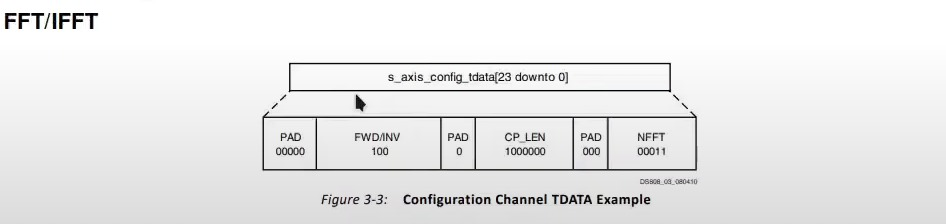

In [6]:
#Pad all values till they are multiple of 8 bits
#Last 5 bits select FFT size
#We can set the values for the second last byte as all zeroes
#The most significant byte to set IP as FFT or inverse FFT, we set its value to 1 as have only one channel

def convert_to_data(fft_direction,size):
    fft_direction.zfill(8) # '011'-> 0000 0011
    
    byte2 = '0'*8
    
    x= int(log(size,2))
    fft_size = bin(x) [2:] # convert it into binary value
    
    fft_size.zfill(8)
    tdata= fft_direction+byte2+fft_size
    return int(tdata,2)
    
    



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [8]:
SAMPLES = 8192 # In case no config is provided FFT defaults to 8192 transform size and all channnels are fwd fft


In [9]:
time_interval = 1
def create_data(SAMPLES,time_interval):
    A1= random.uniform(100,1000)
    A2= random.uniform(100,1000)
    A3 = random.uniform(100,1000)
    f1= random.uniform(100,150)
    f2= random.uniform(200,300)
    f3= random.uniform(500,600)
    w1= 2*np.pi*f1
    w2= 2*np.pi*f2
    w3= 2*np.pi*f3
    t= np.linspace(0,time_interval,SAMPLES)
    data= A1*np.sin(w1*t,dtype=np.csingle) + A2*np.sin(w2*t,dtype=np.csingle)+ A3*np.sin(w3*t,dtype=np.csingle)
    return data,t

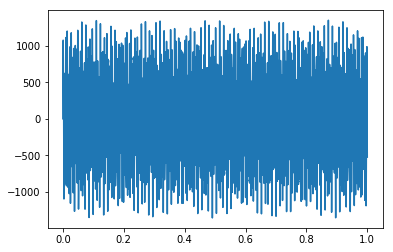

In [10]:
data,t= create_data(SAMPLES,time_interval)
plt.plot(t,np.real(data))

In [11]:
%%time
import time
sw_start= time.time()
output = np.fft.fft(data)
freq= np.fft.fftfreq(SAMPLES*time_interval,1/SAMPLES)
sw_end= time.time()
sw_exec_time = sw_end- sw_start

CPU times: user 12.4 ms, sys: 139 µs, total: 12.6 ms
Wall time: 11.6 ms


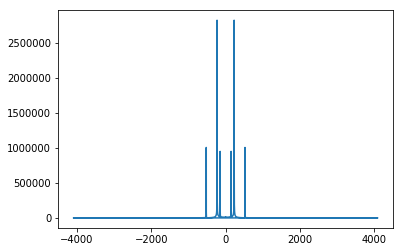

In [12]:
plt.plot(freq,np.abs(output))

In [13]:
from pynq import allocate

In [14]:
input_buffer= allocate(SAMPLES,np.csingle)
output_buffer= allocate(SAMPLES,np.csingle)
np.copyto(input_buffer,data)

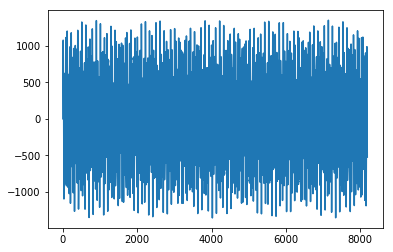

In [15]:
plt.plot(np.real(input_buffer))

In [16]:
%%time
import time
hw_start = time.time()
data_send.transfer(input_buffer)
data_recv.transfer(output_buffer)
data_send.wait()
data_recv.wait()
hw_end = time.time()
hw_exec_time = hw_end-hw_start

CPU times: user 811 µs, sys: 0 ns, total: 811 µs
Wall time: 861 µs


In [17]:
output_buffer

PynqBuffer([ 9744.21875 +0.j     ,  9742.21875 +4.3125j ,
             9743.75000 +6.03125j, ...,  9745.71875-11.j     ,
             9743.78125 -6.15625j,  9742.25000 -4.4375j ], dtype=complex64)

Hardware exec time : 0.0007443428039550781
Software exec time : 0.011409759521484375
Hardware acceleration factor 15.328635490070468


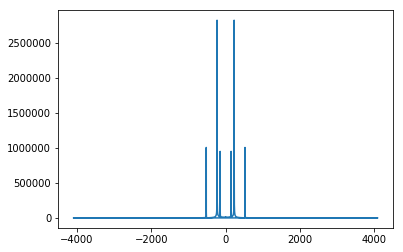

In [18]:
plt.plot(freq,np.abs(output_buffer))
print("Hardware exec time :",hw_exec_time)
print("Software exec time :",sw_exec_time)
print("Hardware acceleration factor",sw_exec_time/hw_exec_time)

In [19]:
SAMPLES =1024 # changing fft size
data,t= create_data(SAMPLES,time_interval)

In [20]:
conf_buffer= allocate(1,np.uint32) #buffer of size 1 which send a uint 32 value
conf_buffer[0]= convert_to_data('1',SAMPLES)


In [21]:
conf_send.transfer(conf_buffer)
conf_send.wait()


In [22]:
input_buffer1= allocate(SAMPLES,np.csingle)
output_buffer1= allocate(SAMPLES,np.csingle)
np.copyto(input_buffer1,data)

In [23]:
%%time
data_send.transfer(input_buffer1)
data_recv.transfer(output_buffer1)
data_send.wait()
data_recv.wait()

CPU times: user 509 µs, sys: 29 µs, total: 538 µs
Wall time: 1.41 ms


In [24]:
output_buffer1

PynqBuffer([ 334.73242188+0.j        ,  334.53515625-2.50390625j,
             335.11914062-4.61132812j, ...,  334.59960938+7.44140625j,
             335.11914062+4.60351562j,  334.53320312+2.49414062j], dtype=complex64)

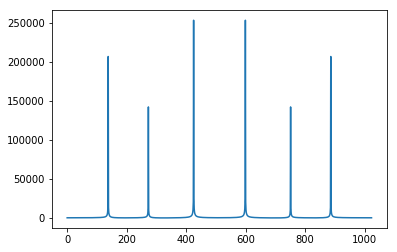

In [25]:
plt.plot(np.abs(output_buffer1))

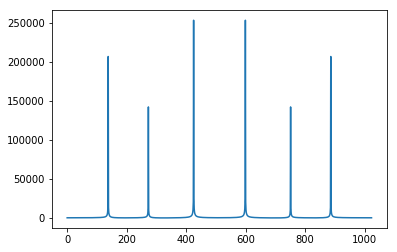

In [26]:
plt.plot(np.abs(np.fft.fft(data)))